# Determining winter strain rates
!! Right now doing whole year for A101 !!

The goal of this notebook is to get a discernable strain rate from winter ApRES data. We expect a constant strain rate throughout the season as no lake drainages are occuring. We will try different methods of stacking to obtain these results.

In [1]:
# Setting up environment
import sys
import pandas as pd
sys.path.append("../../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import importlib
import gcsfs
import math

importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    03:18:16 	 ApRESDefs.py @function _setup_logging line 539 - Stream logging level set to DEBUG
DEBUG    03:18:16 	 ApRESDefs.py @function _setup_logging line 540 - Add console handler to logger
DEBUG    03:18:16 	 ApRESDefs.py @function _setup_logging line 553 - File logging level set to DEBUG


In [2]:
# Set up dask cluster to help with computation
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39075")
client

<Client: 'tcp://127.0.0.1:39075' processes=0 threads=0, memory=0 B>

Let's start with A101

In [3]:
# Loading site data - we use station 101 for now
def reload_summer(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

def reload_winter(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_winter22_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_summer = reload_summer("A101")
ds_winter = reload_winter("A101")



In [4]:
# use pair 1 for A101, 0 for A103 and A104
ds_s = ds_summer.chirp.isel(attenuator_setting_pair=1,time=range(100,len(ds_summer.time)))
ds_w = ds_winter.chirp.isel(attenuator_setting_pair=1)

In [5]:
# define custom profile function
def custom_stacked_profile_series(chirps,pad=2,F0=2e8,F1=4e8):
    StartFreq = 2e8
    StopFreq = 4e8
    B = StopFreq - StartFreq
    CentreFreq = B/2
    K = 2e8 
    dt = 1/40000
    c0 = 3e8 # speed of light in vaccuum
    ER_ICE = 3.18
    T0 = (F0-StartFreq)/K
    T1 = (F1-StartFreq)/K

    chirps = chirps.isel(chirp_time=range(math.ceil(T0/dt),math.floor(T1/dt)+1)).mean(dim='chirp_num')
    window = np.blackman(len(chirps.chirp_time))
    win_chirps = chirps*window
    Nt = len(chirps.chirp_time)
    Nfft = math.floor(Nt*pad)
    bin2m = c0/(2.*(T1-T0)*pad*math.sqrt(ER_ICE)*K)
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    padchirp = np.zeros((len(chirps.time),Nfft))
    padchirp[:,0:math.floor(Nt/2)] = win_chirps.data[:,math.floor(Nt/2):-1]
    padchirp[:,-math.floor(Nt/2):] = win_chirps.data[:,0:math.floor(Nt/2)]
    p = np.fft.fft(padchirp,axis=1)/Nfft * math.sqrt(2*pad)
    profile = p[:,0:math.floor(Nfft/2)-1]
    m = np.asarray([i for i in range(profile.shape[1])])/pad
    phiref = 2*math.pi*CentreFreq*m/B - m * m * 2*math.pi * K/2/B**2
    profile_ref = profile * np.exp(phiref[np.newaxis,:]*(-1j))
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    n = np.argmin(profile_range<=1400)
    Range = profile_range[:n]
    Profile = profile_ref[:,:n]
    da = xr.DataArray(Profile,
                  dims=['time','profile_range'],
                  coords={'profile_range': Range,
                         'time': chirps.time.data})
    return da

In [6]:
da_s_stacked  = custom_stacked_profile_series(ds_s,2,3e8,4e8)
print('Done Summer')
da_w_stacked  = custom_stacked_profile_series(ds_w,2,3e8,4e8)
print('Done Winter')

Done Summer
Done Winter


In [7]:
profiles = xr.concat([da_s_stacked,da_w_stacked],'time')

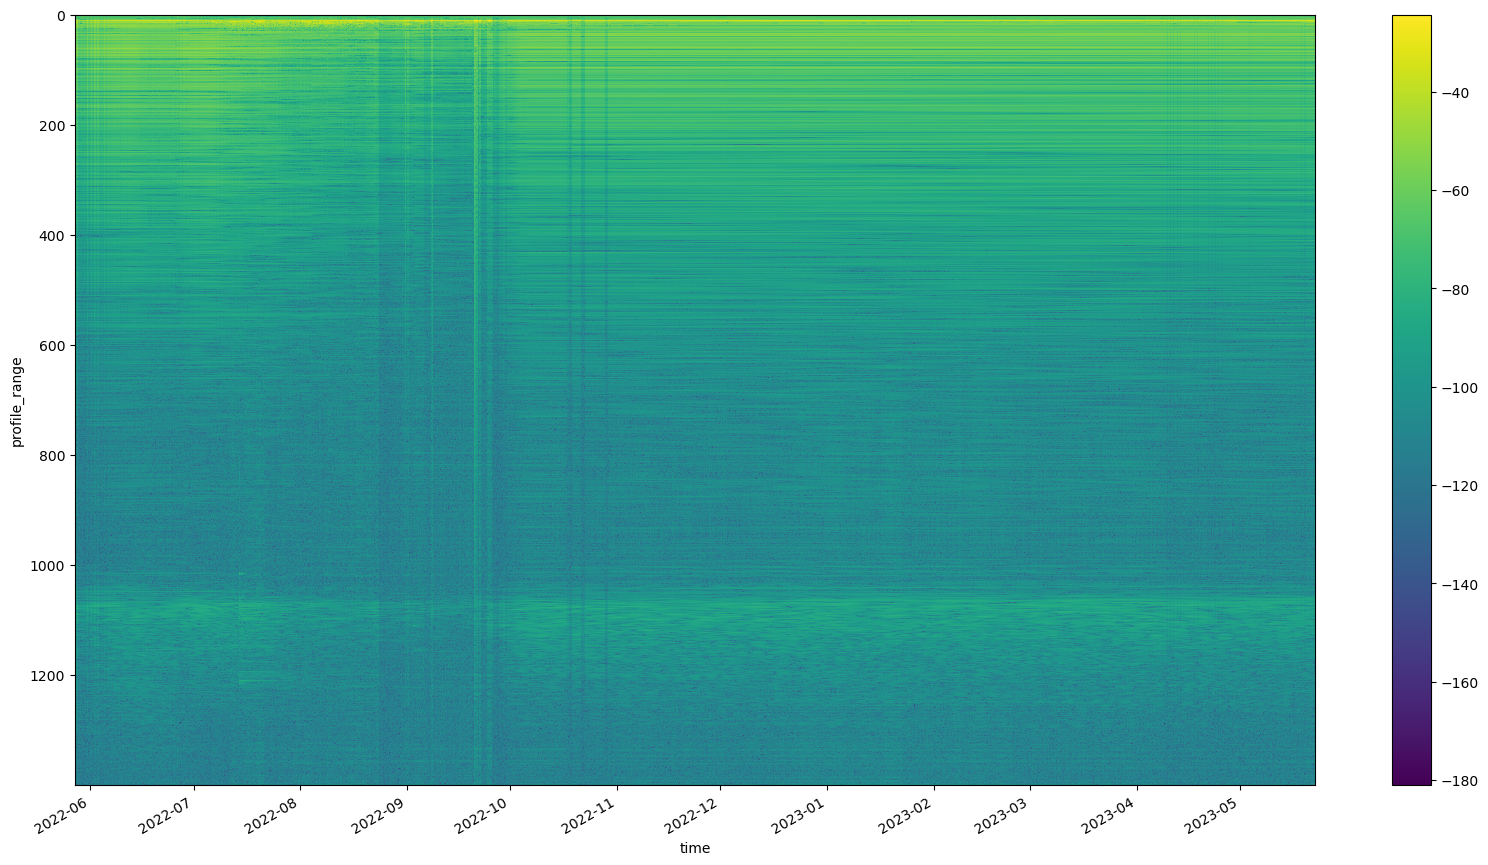

In [8]:
fig, ax = plt.subplots(figsize=(20,30))

ds = xa.dB(profiles)
ds.plot(ax=ax,x='time')
ax.invert_yaxis()

In [9]:
profiles

<xarray.DataArray (time: 34579, profile_range: 3329)>
array([[ 1.08442351e-02+0.00000000e+00j, -5.56188756e-06-9.55414046e-03j,
        -6.45179808e-03+1.35283861e-05j, ...,
        -1.25460886e-07+2.15123420e-06j,  1.88927592e-06+9.42021357e-09j,
         3.42250357e-07-1.47425398e-06j],
       [ 1.08410964e-02+0.00000000e+00j, -5.63868342e-06-9.55125295e-03j,
        -6.44942806e-03+1.35042342e-05j, ...,
         2.13492183e-06+2.69686346e-06j,  2.28879926e-06-1.86404266e-06j,
        -1.12160744e-06-1.24837616e-06j],
       [ 1.08405223e-02+0.00000000e+00j, -6.10033605e-06-9.55098389e-03j,
        -6.44942725e-03+1.42487982e-05j, ...,
        -1.75517930e-06+1.85314032e-06j,  1.02271644e-06+1.45199953e-06j,
         1.25187046e-06-2.52166532e-07j],
       ...,
       [ 1.09316270e-02+0.00000000e+00j, -9.81738352e-06-9.63156052e-03j,
        -6.50711730e-03+1.49563313e-05j, ...,
         8.17987948e-07-1.24546171e-06j, -8.27076399e-07+1.78674120e-06j,
         3.43884524e-06+3.96384405e-07j],
       [ 1.09267730e-02+0.00000000e+00j, -9.72629470e-06-9.62730023e-03j,
        -6.50427957e-03+1.48040416e-05j, ...,
         1.52410764e-06+6.80253806e-07j,  2.18703255e-06+1.27002476e-07j,
         6.64684818e-07-3.02503832e-06j],
       [ 1.09298417e-02+0.00000000e+00j, -9.89313444e-06-9.62995898e-03j,
        -6.50597474e-03+1.50022459e-05j, ...,
         2.89178629e-06+1.85763651e-06j,  2.44068694e-06-1.34129577e-06j,
         1.27044495e-07-3.32793359e-06j]])
Coordinates:
  * profile_range  (profile_range) float64 0.0 0.4206 ... 1.399e+03 1.4e+03
  * time           (time) datetime64[ns] 2022-05-27T13:06:26 ... 2023-05-22T1...

In [10]:
b1 = profiles.isel(time=range(0,len(profiles.time)-1)).where(profiles.profile_range >= 10,drop=True).compute()
b2 = profiles.isel(time=range(1,len(profiles.time))).where(profiles.profile_range >= 10,drop=True).compute()

In [11]:
ds, co, phi = xa.generate_range_diff(b1,b2,19,19,None,0,0.9)

INFO     03:28:41 	 ApRESDefs.py @function generate_range_diff line 594 - Time between bursts : [901. 900. 901. ... 901. 900. 901.]s


In [29]:
ds

<xarray.Dataset>
Dimensions:        (time: 34578, profile_range: 173)
Coordinates:
  * time           (time) datetime64[ns] 2022-05-27T13:21:27 ... 2023-05-22T1...
  * profile_range  (profile_range) float64 13.88 21.87 ... 1.38e+03 1.388e+03
Data variables:
    time_diff      (time) float64 901.0 1.801e+03 ... 3.112e+07 3.112e+07
    range_diff     (time, profile_range) float64 0.001608 0.001356 ... -0.007138
    err            (time, profile_range) float64 0.0004867 ... 0.005552

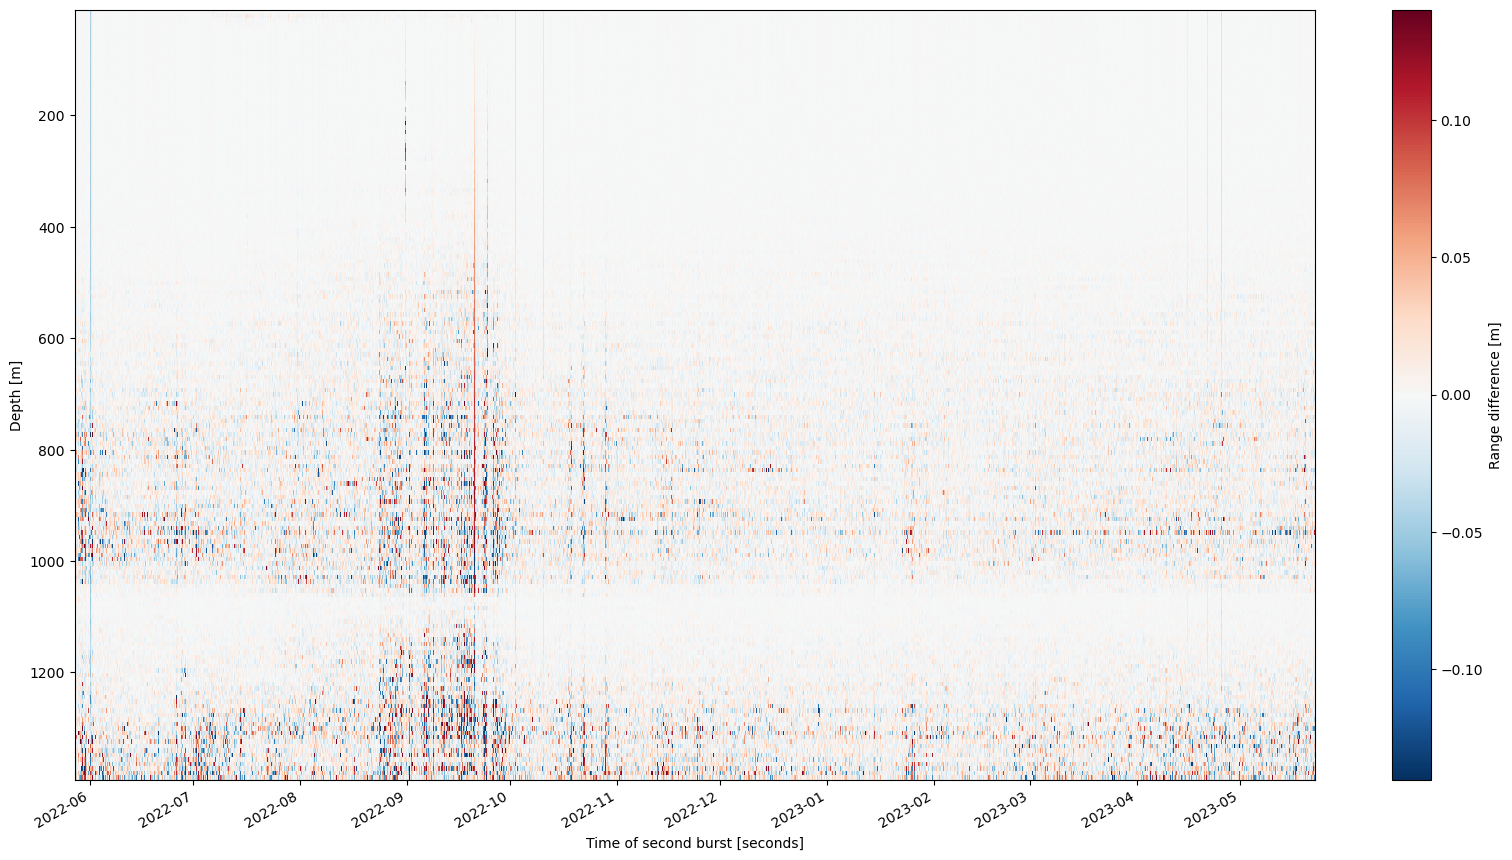

In [12]:
# Range difference
fig, ax = plt.subplots(figsize=(20,10))

ds.range_diff.plot(ax=ax,x='time',cmap='RdBu_r')
ax.invert_yaxis()

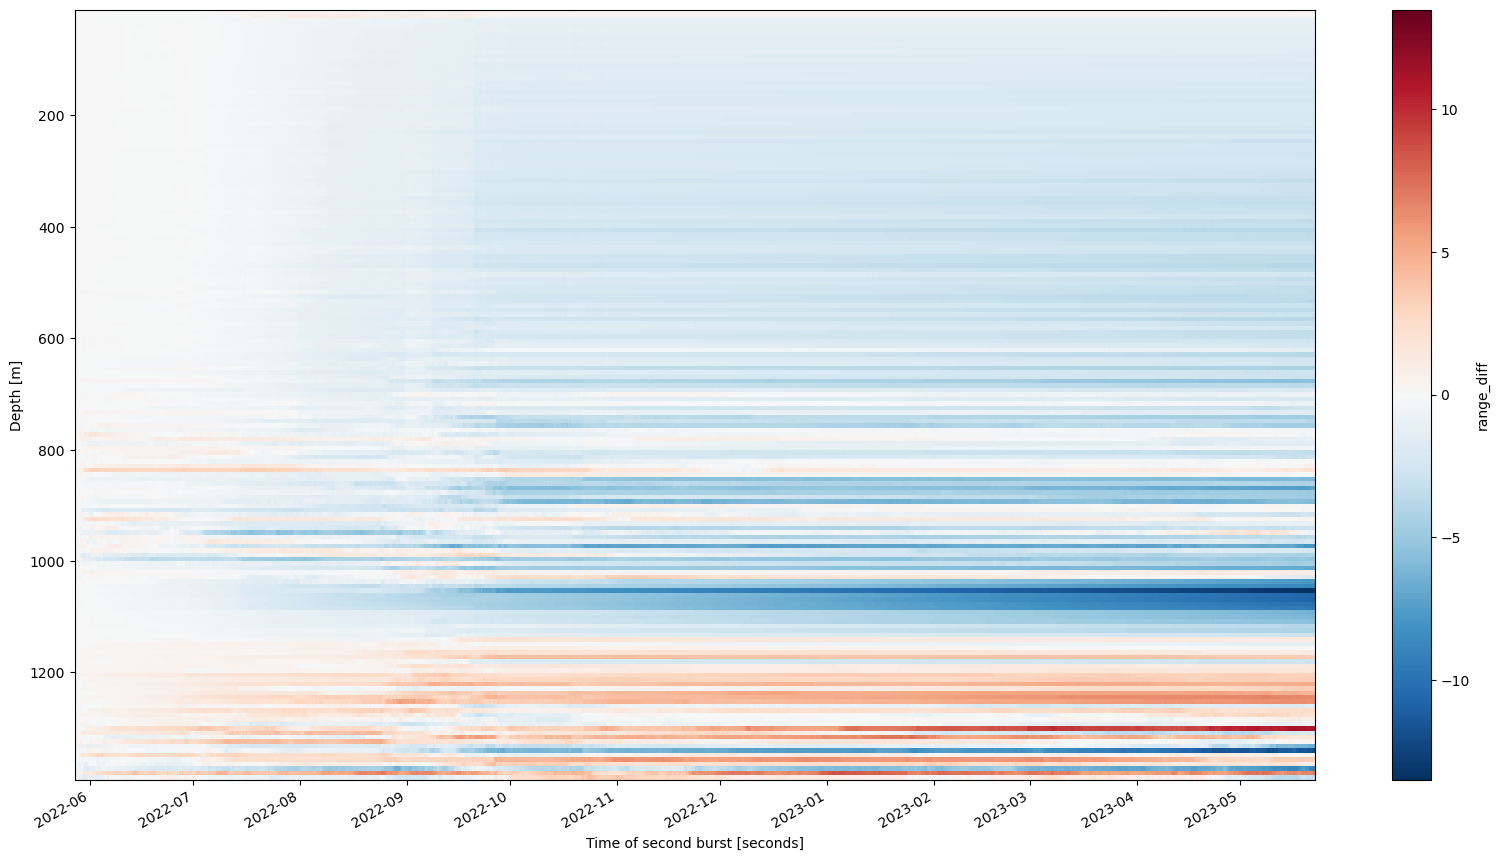

In [13]:
# Total displacement
fig, ax = plt.subplots(figsize=(20,10))

ds.range_diff.cumsum(dim='time').plot(ax=ax,x='time',cmap='RdBu_r')
ax.invert_yaxis()

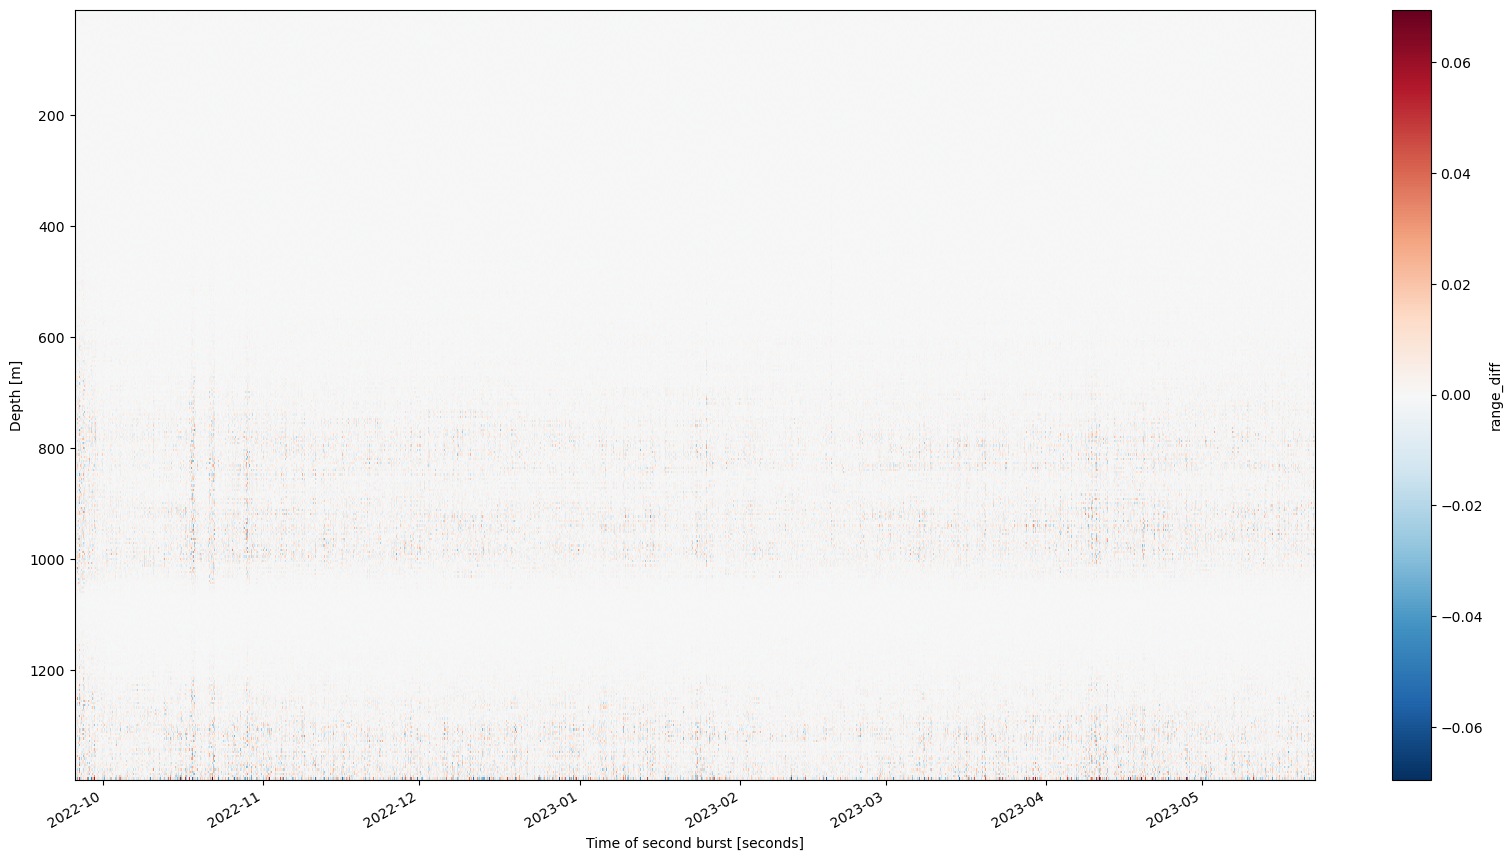

In [17]:
# Strain rates using differentiate
fig, ax = plt.subplots(figsize=(20,10))
strain_rates = ds.range_diff.differentiate('profile_range')
strain_rates.plot(x='time',cmap='RdBu_r')
ax.invert_yaxis()

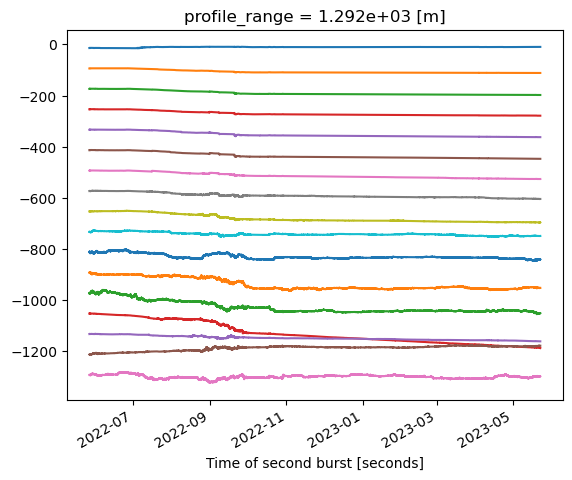

In [15]:
# Plotting displacement for individual layers 
for i in np.arange(0,170,10):
    (10*ds.range_diff.cumsum(dim='time').isel(profile_range = i) - ds.range_diff.profile_range.isel(profile_range = i)).plot()


Let's try stacking in time to get daily displacements and then maybe weekly displacements.


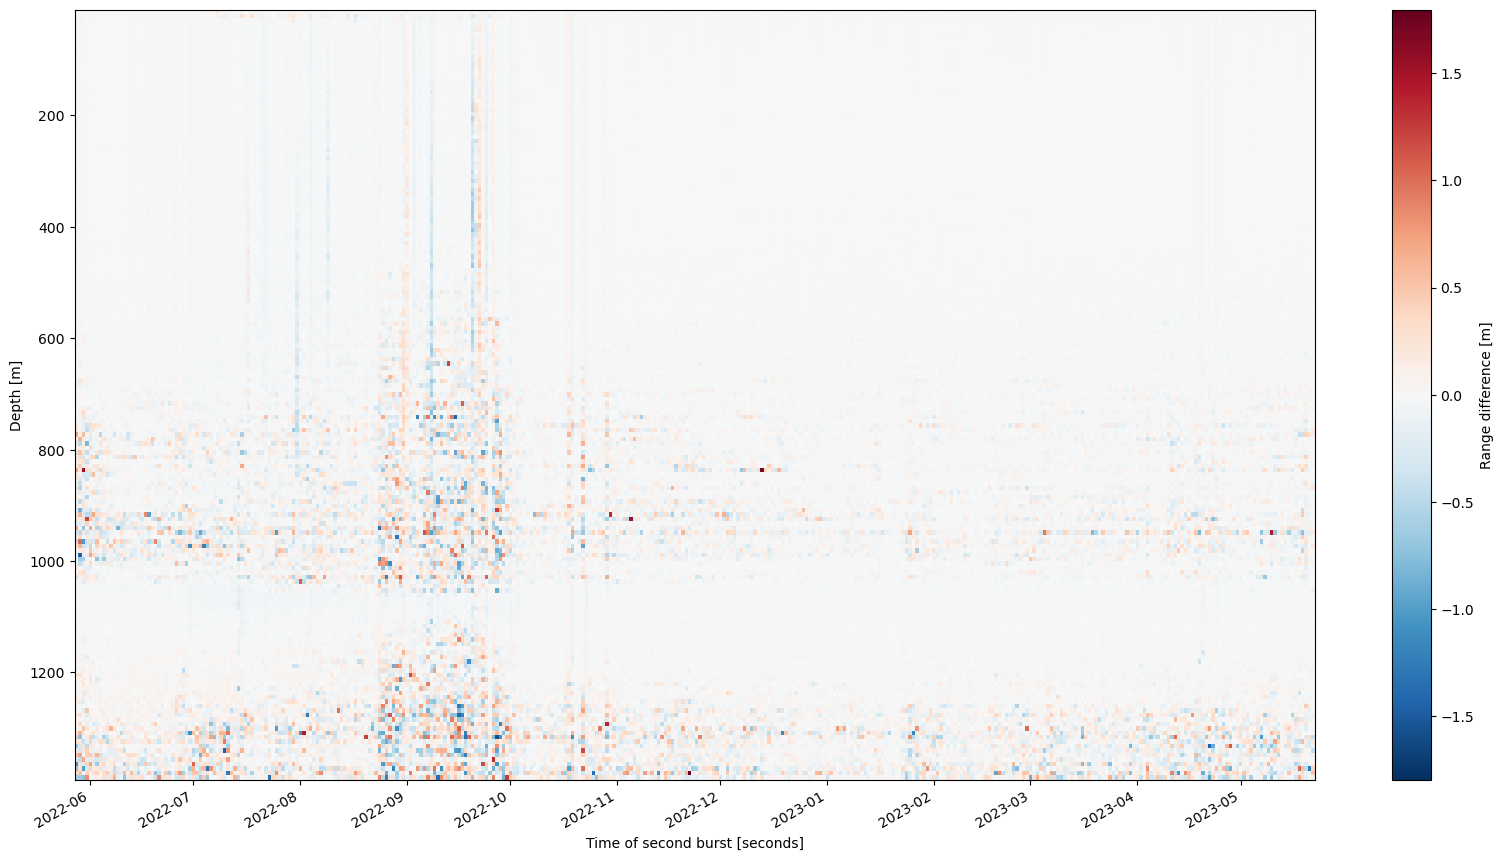

In [16]:
# Daily
# Range difference
fig, ax = plt.subplots(figsize=(20,10))
ds_daily = ds.coarsen(time=96,boundary='trim').sum()
ds_daily.range_diff.plot(ax=ax,x='time',cmap='RdBu_r')
ax.invert_yaxis()

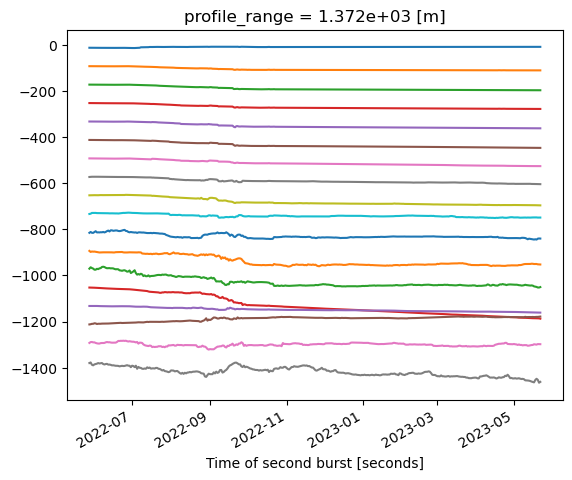

In [18]:
# Plotting displacement for individual layers 
for i in np.arange(0,180,10):
    (10*ds_daily.range_diff.cumsum(dim='time').isel(profile_range = i) - ds_daily.profile_range.isel(profile_range = i)).plot()


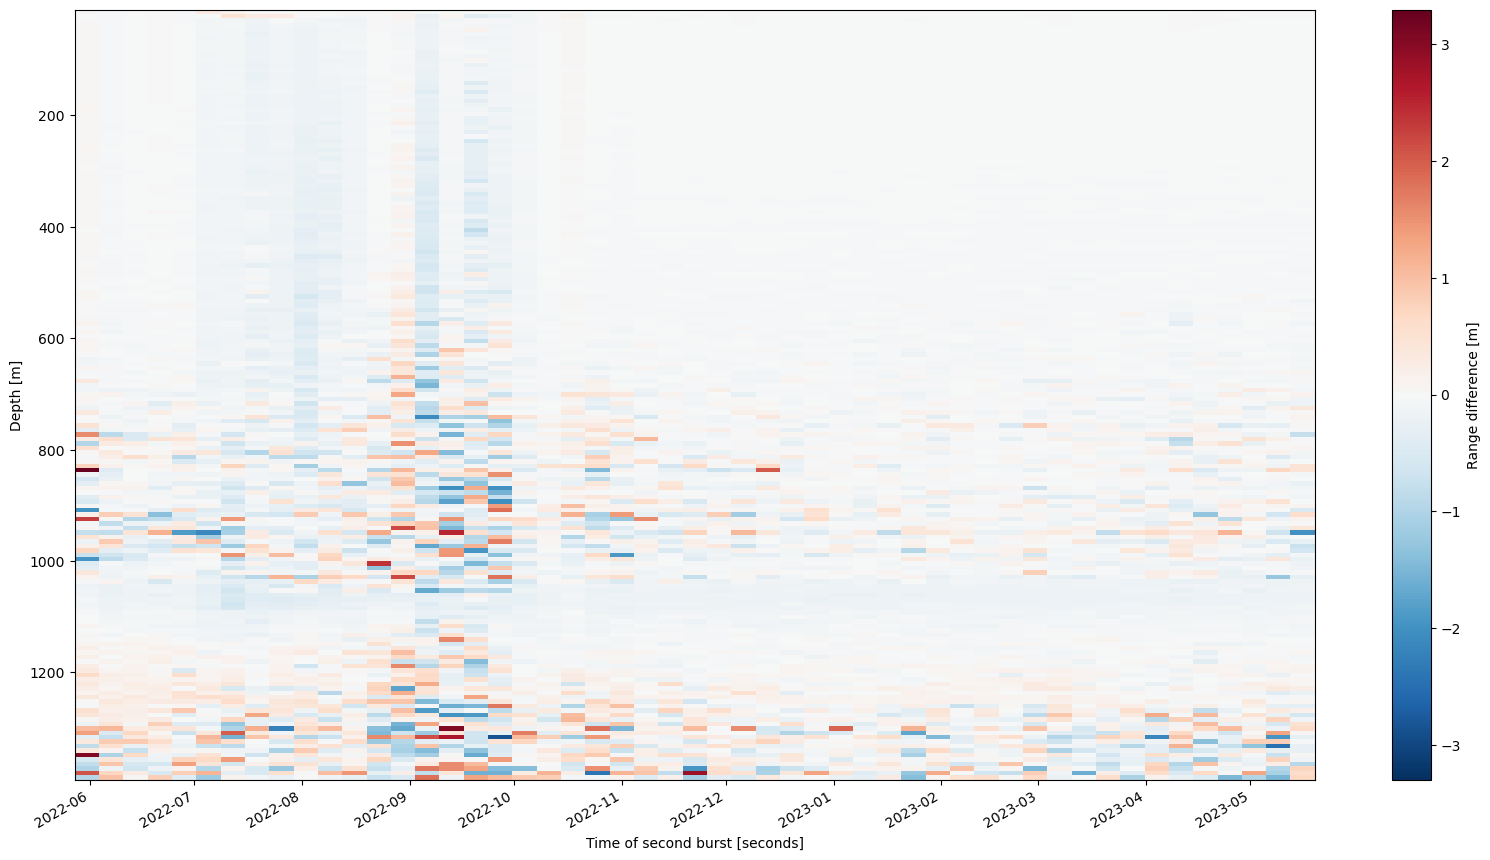

In [19]:
# weekly
# Range difference
fig, ax = plt.subplots(figsize=(20,10))
ds_weekly = ds.coarsen(time=96*7,boundary='trim').sum()
ds_weekly.range_diff.plot(ax=ax,x='time',cmap='RdBu_r')
ax.invert_yaxis()

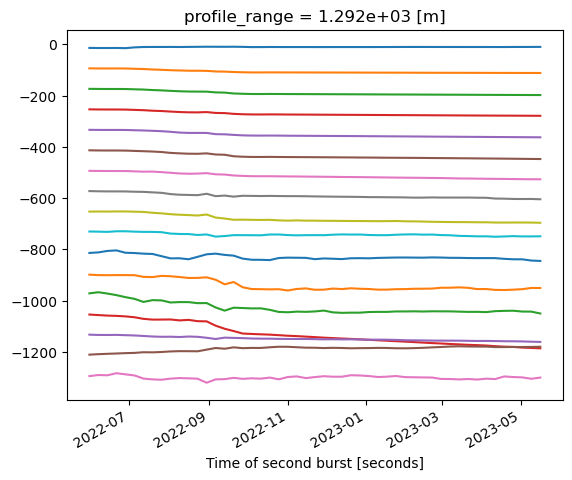

In [20]:
# Plotting displacement for individual layers 
for i in np.arange(0,170,10):
    (10*ds_weekly.range_diff.cumsum(dim='time').isel(profile_range = i) - ds_daily.profile_range.isel(profile_range = i)).plot()


Weekly data is decently clean. Strain rates still not really seen

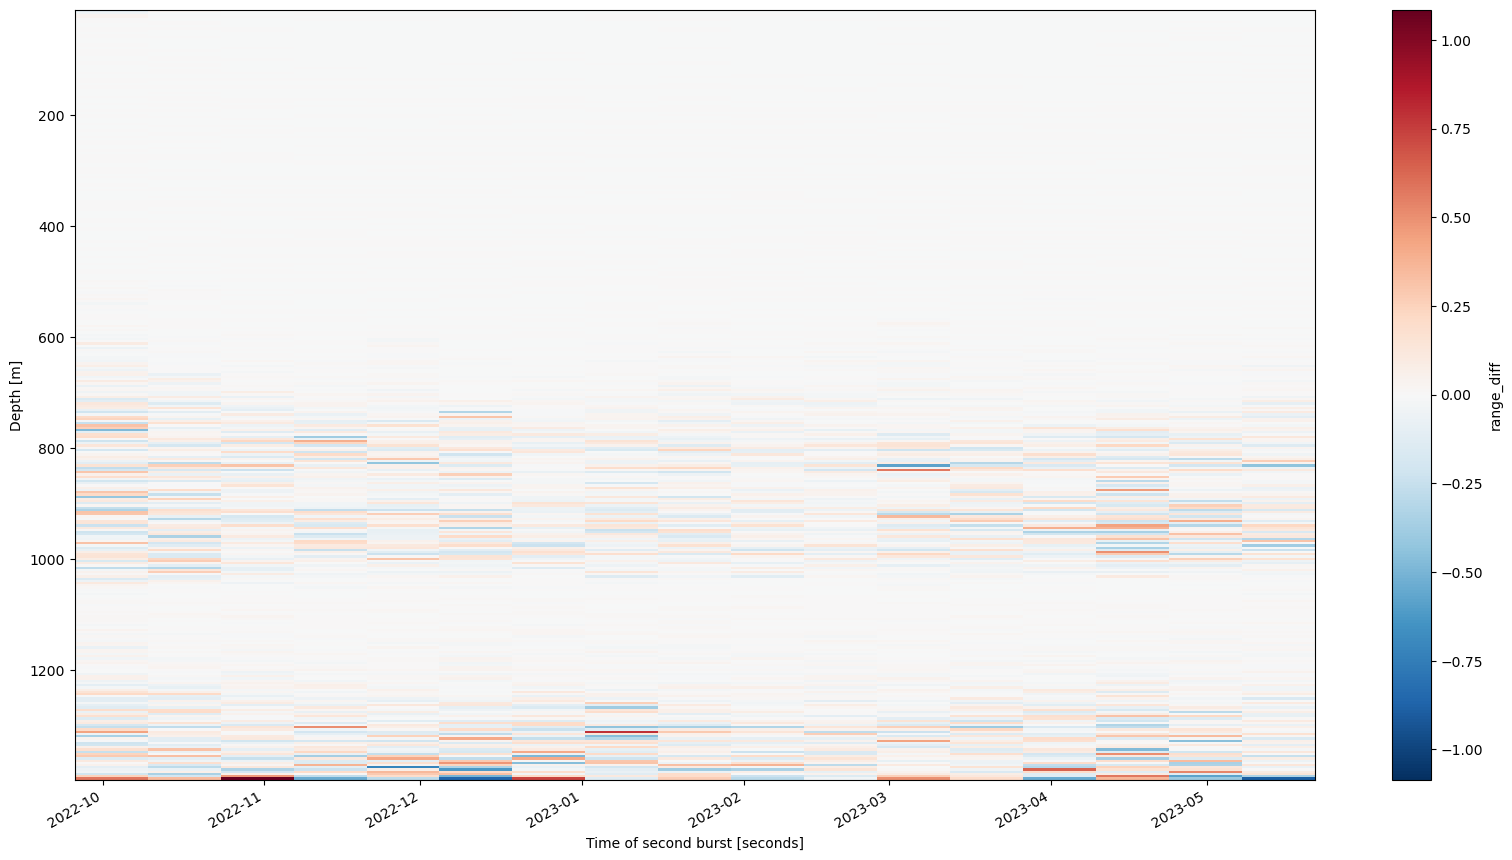

In [127]:
# Strain rates using differentiate
fig, ax = plt.subplots(figsize=(20,10))
strain_rates = ds_weekly.range_diff.differentiate('profile_range')
strain_rates.plot(x='time',cmap='RdBu_r')
ax.invert_yaxis()

Maybe try coarsening in space

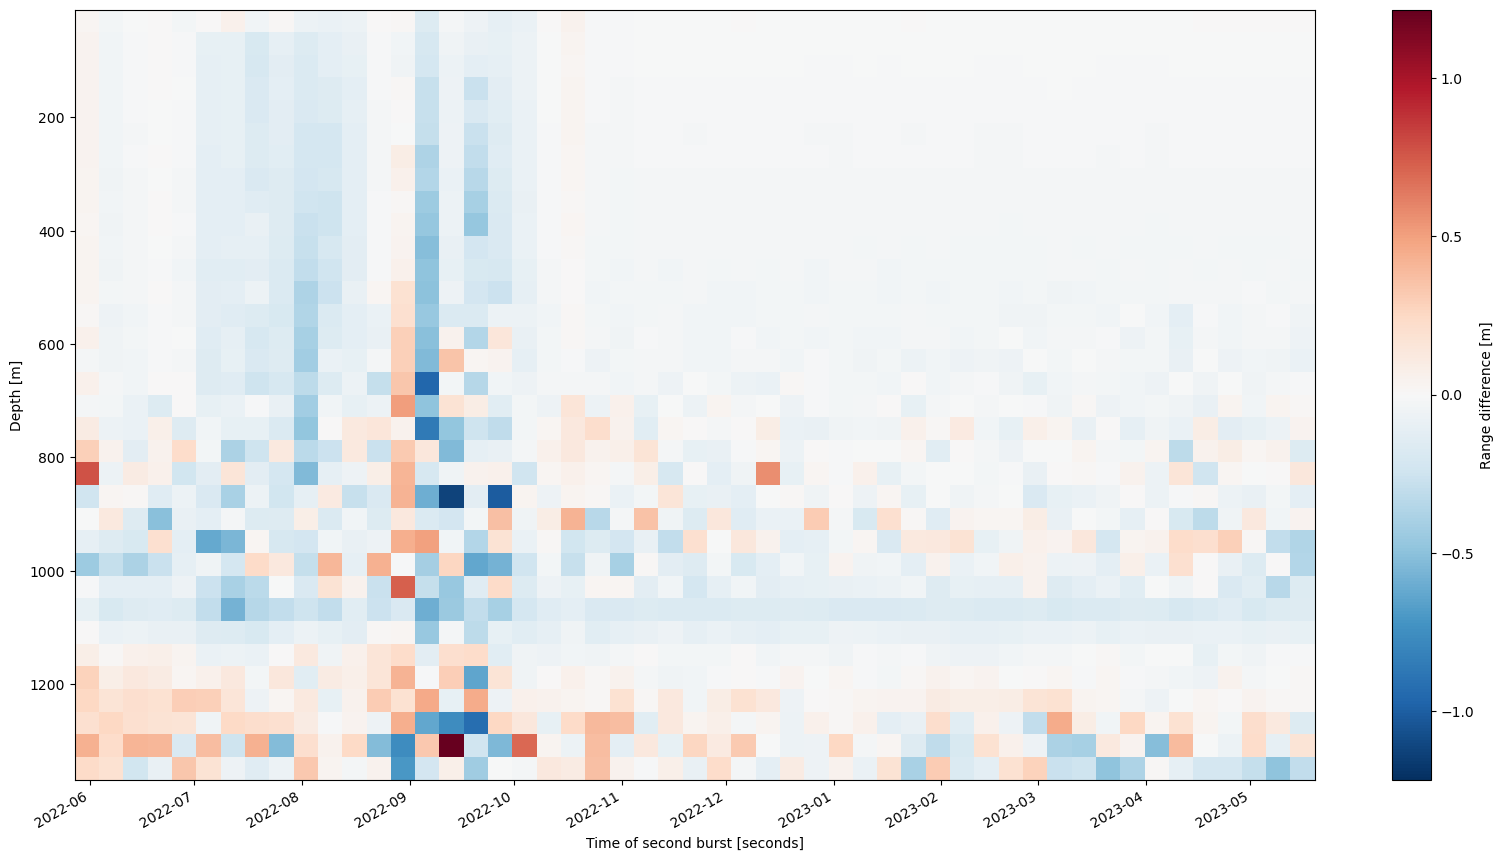

In [21]:
# weekly
# Range difference
fig, ax = plt.subplots(figsize=(20,10))
ds_coarserange = ds_weekly.coarsen(profile_range=5,boundary='trim').mean()
ds_coarserange.range_diff.plot(ax=ax,x='time',cmap='RdBu_r')
ax.invert_yaxis()

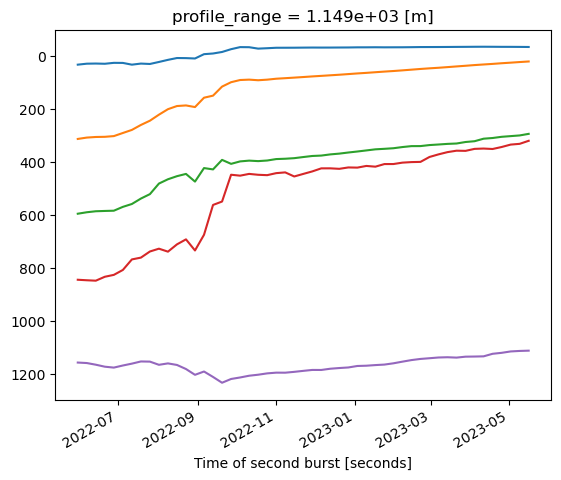

In [24]:
# Plotting displacement for individual layers 
for i in np.arange(0,34,7):
    (100*ds_coarserange.range_diff.cumsum(dim='time').isel(profile_range = i) + ds_coarserange.profile_range.isel(profile_range = i)).plot()
plt.gca().invert_yaxis()

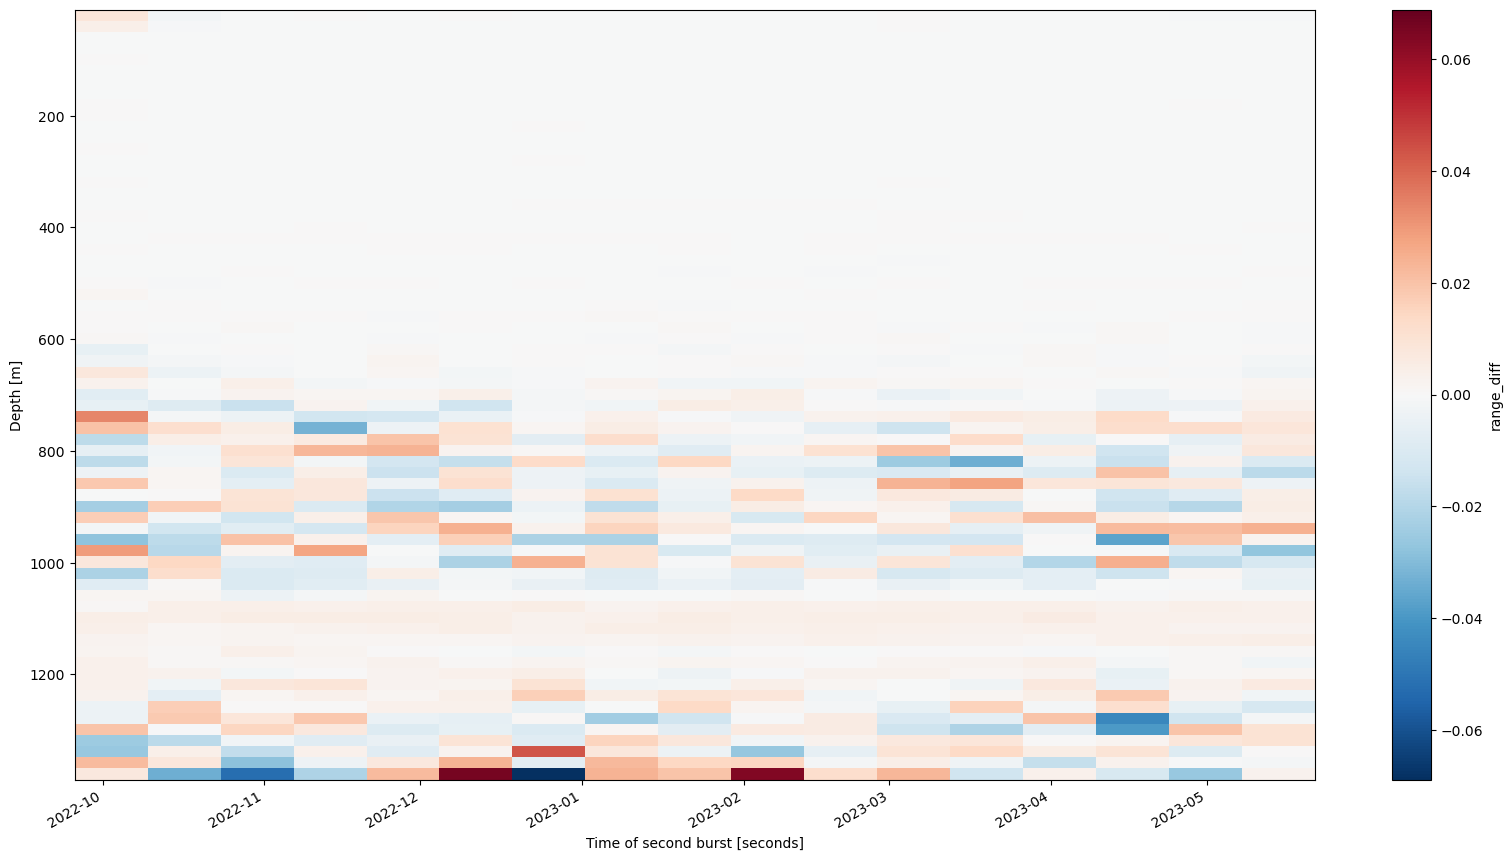

In [130]:
# Strain rates using differentiate
fig, ax = plt.subplots(figsize=(20,10))
strain_rates = ds_coarserange.range_diff.differentiate('profile_range')
strain_rates.plot(x='time',cmap='RdBu_r')
ax.invert_yaxis()

In [25]:
# Try getting strain rates with a linear fit 
strain_polyfit = ds_coarserange.range_diff.where(ds_coarserange.profile_range <= 500,drop=True).polyfit('profile_range',1)

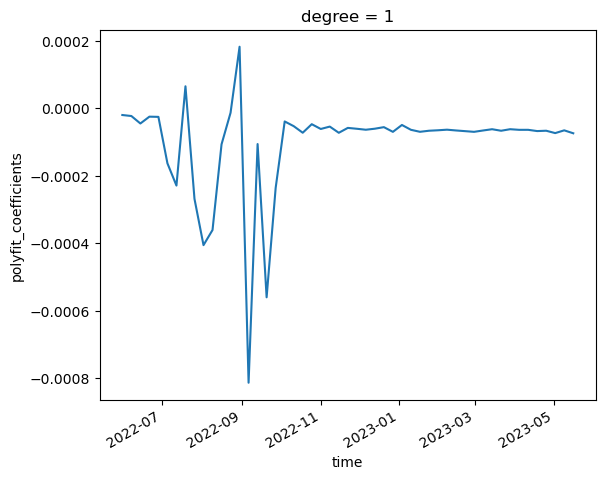

In [26]:
strain_polyfit.polyfit_coefficients.sel(degree=1).plot()

In [27]:
strain_polyfit

<xarray.Dataset>
Dimensions:               (time: 51, degree: 2)
Coordinates:
  * time                  (time) datetime64[ns] 2022-05-31T01:13:53.906250 .....
  * degree                (degree) int64 1 0
Data variables:
    polyfit_coefficients  (degree, time) float64 -1.946e-05 ... 0.002056

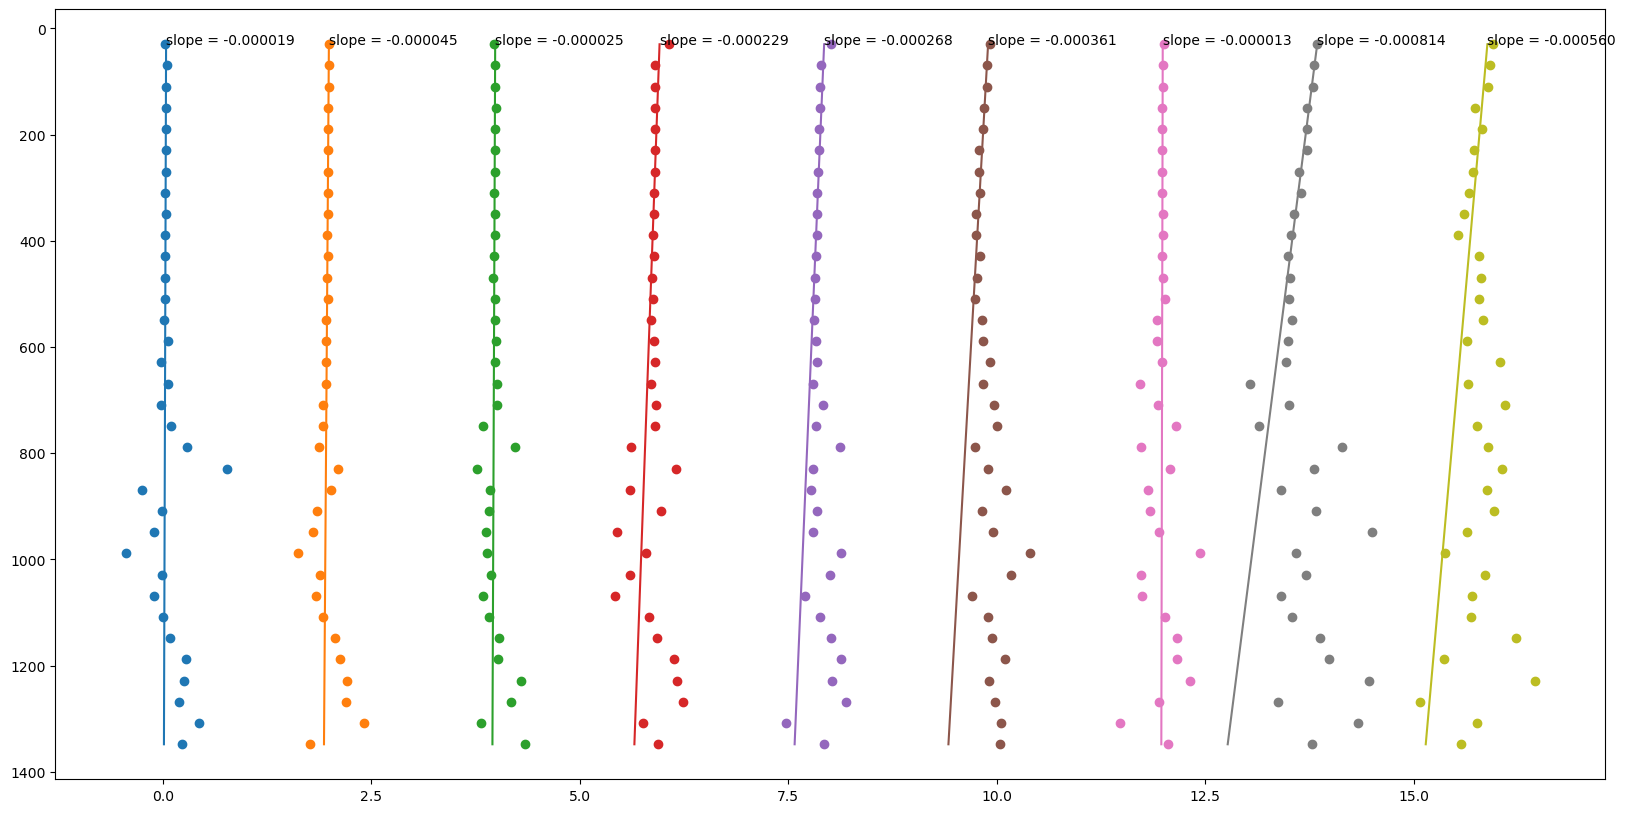

In [28]:
# weekly
# Range difference
fig, ax = plt.subplots(figsize=(20,10))
# Plotting displacement for individual layers 
for i in np.arange(0,17,2):
    plt.scatter(ds_coarserange.range_diff.isel(time = i) + i,ds_coarserange.profile_range)
    fit = strain_polyfit.polyfit_coefficients.sel(degree=1).isel(time=i)*ds_coarserange.profile_range+strain_polyfit.polyfit_coefficients.sel(degree=0).isel(time=i)
    
    plt.plot(fit +i,ds_coarserange.profile_range)
    plt.text(fit[0] +i,ds_coarserange.profile_range[0], f'slope = {strain_polyfit.polyfit_coefficients.sel(degree=1).isel(time=i).values:.6f}')
ax.invert_yaxis()

(-1.0, 1.0)

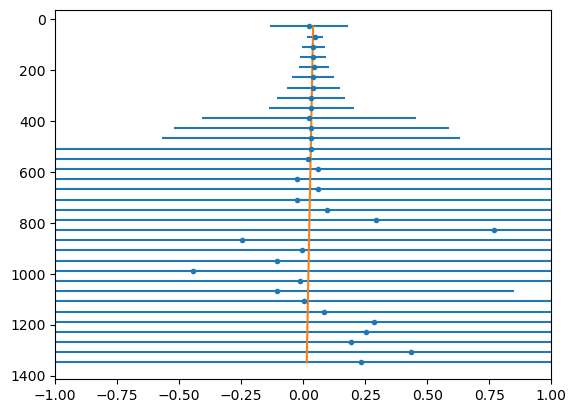

In [30]:
plt.errorbar(ds_coarserange.range_diff.isel(time = 0),ds_coarserange.profile_range,None,abs(ds_coarserange.err.isel(time = 0)),marker='.',linestyle='none')
fit = strain_polyfit.polyfit_coefficients.sel(degree=1).isel(time=0)*ds_coarserange.profile_range+strain_polyfit.polyfit_coefficients.sel(degree=0).isel(time=0)

plt.plot(fit,ds_coarserange.profile_range)
plt.gca().invert_yaxis()
plt.xlim([-1, 1])

In [79]:
ds_coarserange

<xarray.DataArray 'range_diff' (time: 34, profile_range: 69)>
array([[-1.05244555e-01, -1.94497933e-02, -2.37001229e-02, ...,
        -9.14597953e-01, -3.25197311e-01,  3.95958487e-01],
       [-9.75682591e-02, -2.13755481e-02, -1.93016230e-02, ...,
         2.39362411e-02,  1.66337193e-01, -4.05379141e-01],
       [ 1.50323898e-02,  1.36393958e-03, -7.85083773e-04, ...,
        -1.61903887e-01,  2.18536444e-01,  3.39009106e-02],
       ...,
       [ 4.69679916e-03, -1.68746213e-03, -2.87896216e-03, ...,
        -2.30560124e-01,  1.33981543e-01,  4.00053906e-01],
       [ 2.88725267e-03, -1.20146651e-03, -2.50805636e-03, ...,
         1.82415381e-01,  5.57001981e-01, -3.04424710e-02],
       [ 5.90403962e-03, -1.62234308e-03, -2.75496030e-03, ...,
         9.62198915e-02, -3.90082907e-01,  2.56284041e-01]])
Coordinates:
  * time           (time) datetime64[ns] 2022-09-29T03:41:36.254464285 ... 20...
  * profile_range  (profile_range) float64 19.98 39.96 ... 1.358e+03 1.378e+03
Attributes:
    units:      m
    long_name:  Range difference